https://medium.com/nerd-for-tech/building-an-object-detector-in-tensorflow-using-bounding-box-regression-2bc13992973f

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [2]:
# Base settings

# path to image directory and annotation JSON file
BASE_PATH = "dataset"

# Path to images
IMAGES_PATH = os.path.sep.join([BASE_PATH, "train"])

# Path to bounding box annotations 
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "COCO_train_single_BB.json"])

# Path to output model
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training plot, and testing image filenames
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])


# initialize our initial learning rate, number of epochs to train for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 30
BATCH_SIZE = 32

width = 224
height = 224
num_classes = 2
classes = ["Damage", "No-Damage"]

The following Code section is responsible for loading the JSON file (COCO format) which contains information about the images and their respective bounding boxes.

In [3]:
import json

with open(ANNOTS_PATH) as json_file:
    annot_json = json.load(json_file) 

data = []
targets = []
labels = []
filenames = []

for img in annot_json['images']:
    filename = img['file_name']
    
    startX = img['bbox'][0]
    startY = img['bbox'][1]
    endX = startX + img['bbox'][2]
    endY = startY + img['bbox'][3]

    # derive the path to the input image, load the image (in OpenCV
    # format), and grab its dimensions
    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2] 
        
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h

    # load the image and preprocess it
    image = load_img(imagePath, target_size=(width, height))
    image = img_to_array(image)
    # update our list of data, targets, and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    labels.append(classes.index(img['class']))
    filenames.append(filename)
            
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
labels = np.array(labels)
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, labels, filenames, test_size=0.10,random_state=42)

# unpack the data split
(train_images, validation_images) = split[:2]
(train_targets, validation_targets) = split[2:4]
(train_labels, validation_labels) = split[4:6]
(train_filenames, validation_filenames) = split[6:]

In [4]:
# Create VGG16 model with a fully-connected layer to output the predicted bounding box coordinates
vgg = VGG16(weights='imagenet',
            include_top=False,
            input_shape=(224,224,3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
# #create the common input layer
# input_shape = (height, width, 3)
# input_layer = Input(input_shape)

# #create the base layers
# base_layers = Rescaling(1./255, name='bl_1')(input_layer)
# base_layers = Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
# base_layers = MaxPooling2D(name='bl_3')(base_layers)
# base_layers = Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
# base_layers = MaxPooling2D(name='bl_5')(base_layers)
# base_layers = Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
# base_layers = MaxPooling2D(name='bl_7')(base_layers)
# base_layers = Flatten(name='bl_8')(base_layers)

In [6]:
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

In [7]:
# create the classifier branch
classifier_branch = Dense(128, activation="relu", name="cl_1")(flatten)
#classifier_branch = Dropout(0.2)(classifier_branch)
classifier_branch = Dense(num_classes, name="cl_head", activation="softmax")(classifier_branch)

In [8]:
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
locator_branch = Dense(128, activation="relu", name="bb_1")(flatten)
locator_branch = Dropout(0.2)(locator_branch)
locator_branch = Dense(64, activation="relu", name="bb_2")(locator_branch)
locator_branch = Dropout(0.2)(locator_branch)
locator_branch = Dense(32, activation="relu", name="bb_3")(locator_branch)
locator_branch = Dropout(0.2)(locator_branch)

# This layer will output the 4 coordinates x1, y1, x2, y2 
locator_branch = Dense(4, activation="sigmoid", name="bb_head")(locator_branch)

# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=[classifier_branch, locator_branch])

In [9]:
# initialize the optimizer, compile the model, and show the model summary
losses = {
    "cl_head": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    "bb_head": tf.keras.losses.MSE}
opt = Adam(learning_rate=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [10]:
trainTargets = {
    "cl_head": train_labels,
    "bb_head": train_targets
}
validationTargets = {
    "cl_head": validation_labels,
    "bb_head": validation_targets
}

In [11]:
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	train_images, trainTargets,
	validation_data=(validation_images, validationTargets),
	batch_size= BATCH_SIZE,
	epochs= NUM_EPOCHS,
    shuffle=True,
	verbose=1)

[INFO] training bounding box regressor...
Epoch 1/30


C:\Users\benna\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2/2 [==============================] - 18s 9s/step - loss: 0.2407 - cl_head_loss: 0.1218 - bb_head_loss: 0.1189 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.1905 - val_loss: 0.0255 - val_cl_head_loss: 2.6431e-04 - val_bb_head_loss: 0.0253 - val_cl_head_accuracy: 1.0000 - val_bb_head_accuracy: 0.4286
Epoch 2/30
2/2 [==============================] - 14s 7s/step - loss: 0.0608 - cl_head_loss: 1.1162e-04 - bb_head_loss: 0.0607 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.5238 - val_loss: 0.0209 - val_cl_head_loss: 6.1137e-06 - val_bb_head_loss: 0.0209 - val_cl_head_accuracy: 1.0000 - val_bb_head_accuracy: 0.4286
Epoch 3/30
2/2 [==============================] - 14s 8s/step - loss: 0.0541 - cl_head_loss: 2.5204e-06 - bb_head_loss: 0.0541 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.5079 - val_loss: 0.0216 - val_cl_head_loss: 5.2793e-07 - val_bb_head_loss: 0.0216 - val_cl_head_accuracy: 1.0000 - val_bb_head_accuracy: 0.4286
Epoch 4/30
2/2 [==============================] - 14s 7

Epoch 27/30
2/2 [==============================] - 14s 8s/step - loss: 0.0247 - cl_head_loss: 0.0000e+00 - bb_head_loss: 0.0247 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.6349 - val_loss: 0.0212 - val_cl_head_loss: 0.0000e+00 - val_bb_head_loss: 0.0212 - val_cl_head_accuracy: 1.0000 - val_bb_head_accuracy: 0.5714
Epoch 28/30
2/2 [==============================] - 14s 8s/step - loss: 0.0232 - cl_head_loss: 0.0000e+00 - bb_head_loss: 0.0232 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.6190 - val_loss: 0.0207 - val_cl_head_loss: 0.0000e+00 - val_bb_head_loss: 0.0207 - val_cl_head_accuracy: 1.0000 - val_bb_head_accuracy: 0.5714
Epoch 29/30
2/2 [==============================] - 14s 8s/step - loss: 0.0206 - cl_head_loss: 0.0000e+00 - bb_head_loss: 0.0206 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.6190 - val_loss: 0.0202 - val_cl_head_loss: 0.0000e+00 - val_bb_head_loss: 0.0202 - val_cl_head_accuracy: 1.0000 - val_bb_head_accuracy: 0.5714
Epoch 30/30
2/2 [====================

Save the trained Model

Save object detector model to subfolder 'output'


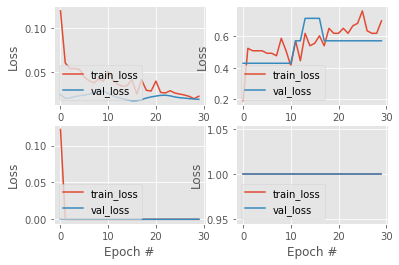

In [12]:
print(f"Save object detector model to subfolder '{BASE_OUTPUT}'")
model.save(MODEL_PATH, save_format="h5")
# plot the model training history
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.subplot(2,2,1)
plt.plot(np.arange(0, N), H.history["bb_head_loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_bb_head_loss"], label="val_loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
plt.subplot(2,2,2)
plt.plot(np.arange(0, N), H.history["bb_head_accuracy"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_bb_head_accuracy"], label="val_loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
plt.subplot(2,2,3)
plt.plot(np.arange(0, N), H.history["cl_head_loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_cl_head_loss"], label="val_loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
plt.subplot(2,2,4)
plt.plot(np.arange(0, N), H.history["cl_head_accuracy"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_cl_head_accuracy"], label="val_loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

### Training model for classification

In [13]:
# Path to images
IMAGES_PATH = os.path.sep.join([BASE_PATH, "train_all"])

# Path to bounding box annotations 
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "COCO_train_all_single_BB.json"])

In [14]:
import json

with open(ANNOTS_PATH) as json_file:
    annot_json = json.load(json_file) 

data = []
targets = []
labels = []
filenames = []

for img in annot_json['images']:
    filename = img['file_name']
    
    startX = img['bbox'][0]
    startY = img['bbox'][1]
    endX = startX + img['bbox'][2]
    endY = startY + img['bbox'][3]

    # derive the path to the input image, load the image (in OpenCV
    # format), and grab its dimensions
    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2] 
        
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h

    # load the image and preprocess it
    image = load_img(imagePath, target_size=(width, height))
    image = img_to_array(image)
    # update our list of data, targets, and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    labels.append(classes.index(img['class']))
    filenames.append(filename)
            
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
labels = np.array(labels)
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, labels, filenames, test_size=0.10,random_state=42)

# unpack the data split
(train_images, validation_images) = split[:2]
(train_targets, validation_targets) = split[2:4]
(train_labels, validation_labels) = split[4:6]
(train_filenames, validation_filenames) = split[6:]

In [15]:
for layer in model.layers:
    if layer.name.startswith('bl'):
        layer.trainable = False
        
for layer in model.layers:
    if layer.name.startswith('bb_'):
        layer.trainable = False

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [17]:
trainTargets = {
    "cl_head": train_labels,
    "bb_head": train_targets
}
validationTargets = {
    "cl_head": validation_labels,
    "bb_head": validation_targets
}

In [18]:
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	train_images, trainTargets,
	validation_data=(validation_images, validationTargets),
	batch_size= BATCH_SIZE,
	epochs= NUM_EPOCHS,
    shuffle=True,
	verbose=1)

[INFO] training bounding box regressor...
Epoch 1/30
5/5 [==============================] - 35s 7s/step - loss: 11.1421 - cl_head_loss: 10.9626 - bb_head_loss: 0.1794 - cl_head_accuracy: 0.4052 - bb_head_accuracy: 0.2745 - val_loss: 3.3126 - val_cl_head_loss: 3.1696 - val_bb_head_loss: 0.1430 - val_cl_head_accuracy: 0.4706 - val_bb_head_accuracy: 0.3529
Epoch 2/30
5/5 [==============================] - 35s 7s/step - loss: 1.5919 - cl_head_loss: 1.4285 - bb_head_loss: 0.1633 - cl_head_accuracy: 0.4444 - bb_head_accuracy: 0.2418 - val_loss: 0.8211 - val_cl_head_loss: 0.6910 - val_bb_head_loss: 0.1302 - val_cl_head_accuracy: 0.5294 - val_bb_head_accuracy: 0.1765
Epoch 3/30
5/5 [==============================] - 35s 7s/step - loss: 0.7981 - cl_head_loss: 0.6478 - bb_head_loss: 0.1503 - cl_head_accuracy: 0.5948 - bb_head_accuracy: 0.2288 - val_loss: 0.8042 - val_cl_head_loss: 0.6789 - val_bb_head_loss: 0.1253 - val_cl_head_accuracy: 0.5294 - val_bb_head_accuracy: 0.1176
Epoch 4/30
5/5 [====

5/5 [==============================] - 32s 6s/step - loss: 0.3703 - cl_head_loss: 0.3153 - bb_head_loss: 0.0550 - cl_head_accuracy: 0.9542 - bb_head_accuracy: 0.2484 - val_loss: 0.6318 - val_cl_head_loss: 0.5738 - val_bb_head_loss: 0.0580 - val_cl_head_accuracy: 0.5882 - val_bb_head_accuracy: 0.2353
Epoch 28/30
5/5 [==============================] - 31s 6s/step - loss: 0.3665 - cl_head_loss: 0.3127 - bb_head_loss: 0.0538 - cl_head_accuracy: 0.9412 - bb_head_accuracy: 0.2810 - val_loss: 0.6413 - val_cl_head_loss: 0.5813 - val_bb_head_loss: 0.0600 - val_cl_head_accuracy: 0.5882 - val_bb_head_accuracy: 0.1765
Epoch 29/30
5/5 [==============================] - 32s 7s/step - loss: 0.3607 - cl_head_loss: 0.3106 - bb_head_loss: 0.0501 - cl_head_accuracy: 0.9739 - bb_head_accuracy: 0.2745 - val_loss: 0.6338 - val_cl_head_loss: 0.5744 - val_bb_head_loss: 0.0594 - val_cl_head_accuracy: 0.5882 - val_bb_head_accuracy: 0.1765
Epoch 30/30
5/5 [==============================] - 31s 6s/step - loss: 0.

Save object detector model to subfolder 'output'


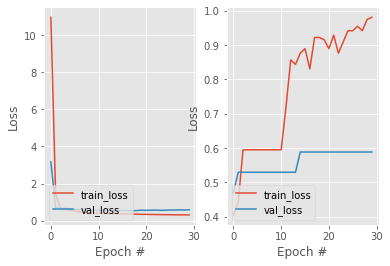

In [20]:
print(f"Save object detector model to subfolder '{BASE_OUTPUT}'")
model.save(MODEL_PATH, save_format="h5")
plt.subplot(1,2,1)
plt.plot(np.arange(0, N), H.history["cl_head_loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_cl_head_loss"], label="val_loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
plt.subplot(1,2,2)
plt.plot(np.arange(0, N), H.history["cl_head_accuracy"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_cl_head_accuracy"], label="val_loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)